# **Projet 5 - <span style="color:#1d479b">Segmentez les clients d'un site e-commerce</span>**
---

**<span style="color:#1d479b">Objectif de la mission:</span>**
* Fournir une **segmentation des clients** afin d'apporter des informations supplémentaires aux équipes pour leurs campagnes de communication.
* **Comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.
* Fournir une **description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale.
* Proposition de **contrat de maintenance basée sur une analyse de la stabilité** des segments au cours du temps..

## **0. Importation des librairies et des données**
---

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# ---
#scikit-learn
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#classe pour l'ACP
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
#Classes pour le clustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
path_customers = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P5_Segmentez_Des_Clients_Dun_Site_e_commerce/df_final.csv"
df_customers = pd.read_csv(path_customers, sep=",")
df = df_customers.copy()

### **0.1 - Définition de la charte graphique**

In [3]:
["#0B28D0","#A2A2D5","#FFF","#333","#EDAD01"]

['#0B28D0', '#A2A2D5', '#FFF', '#333', '#EDAD01']

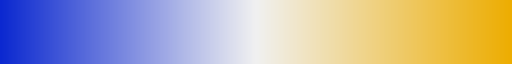

In [4]:
# Define the heatmap color
first_color = "#0B28D0"
under_color = "#F1F1F1"
over_color = "#EDAD01"
# Create a personal color map 
colors = [first_color,under_color, over_color]
n_bins = 400
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

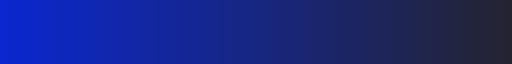

In [5]:
palette_b = sns.dark_palette("#0B28D0", reverse=True, as_cmap=True)
palette_b

In [6]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#0B28D0", n_colors=n_colors,as_cmap=False)
palette_map

[(0.14217064351973224, 0.14390410693260464, 0.19354284782618525),
 (0.13129638908327107, 0.14532701622135824, 0.26185663585419044),
 (0.12042213464680988, 0.14674992551011184, 0.33017042388219564),
 (0.10915951398047509, 0.1482236529877495, 0.4009239900540581),
 (0.0982852595440139, 0.1496465622765031, 0.4692377780820633),
 (0.08702263887767911, 0.15112028975414074, 0.5399913442539259),
 (0.07614838444121794, 0.15254319904289435, 0.6083051322819311),
 (0.06488576377488314, 0.154016926520532, 0.6790586984537935),
 (0.05401150933842197, 0.1554398358092856, 0.7473724864817987),
 (0.043137254901960784, 0.1568627450980392, 0.8156862745098039)]

### **0.2 - Normalisation de l'affichage des graphiques**

In [7]:
# Defines display options for rows and columns
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#EDAD01'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

In [9]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16, 
                  "axes.labelsize":10, 
                  "xtick.labelsize":8, 
                  "ytick.labelsize":8, 
                  "xtick.color":"#333", 
                  "ytick.color":"#333", 
                  "axes.titlecolor":"#000", 
                  "axes.labelcolor":"#EDAD01"
                  })

## **1. Traitement des données**
***

In [10]:
df.sample(1)

,customer_unique_id,review_score,payment_installments,payment_sequential,average_price,average_freight_value,average_product_weight_g,product_volume_cm3,nb_product_per_order,days_since_last_order,nb_orders_per_customer
1469,03f73fe651d978936b253769873bc2e9,5.0,2.0,1.0,72.99,88.02,7500.0,30866.0,1.0,44.0,1.0


La colonne `customer_unique_id` est supprimée pour le clustering.

In [11]:
df = df.drop(columns="customer_unique_id")

Les données sont normalisées à 2 chiffres après la virgule.

In [12]:
df = df.round(2)

Et les types des données est vérifié avant le clustering.

In [13]:
df.dtypes

review_score                float64
payment_installments        float64
payment_sequential          float64
average_price               float64
average_freight_value       float64
average_product_weight_g    float64
product_volume_cm3          float64
nb_product_per_order        float64
days_since_last_order       float64
nb_orders_per_customer      float64
dtype: object

## **2. Clustering**
***

Le clustering est testé dans un premier temps à partir des données minimales d'une segmentation RFM (Récence,Fréquence,Montant) + `review_score`.

Cette segmentation n'ayant pas permit une dichotomie des clients suffisamment pertinente, la variable `payment_installments` a été ajouté aux données.

In [14]:
df_cluster = df[["review_score","payment_installments","average_price","days_since_last_order","nb_orders_per_customer"]]

Il est interessant d'observer les associations entre les variables avant le clustering puisque la présence de variables avec une corrélation forte signifie potentiellement que l'ont apporte une même information, ce qui peut être contre-productif pour une segmentation.

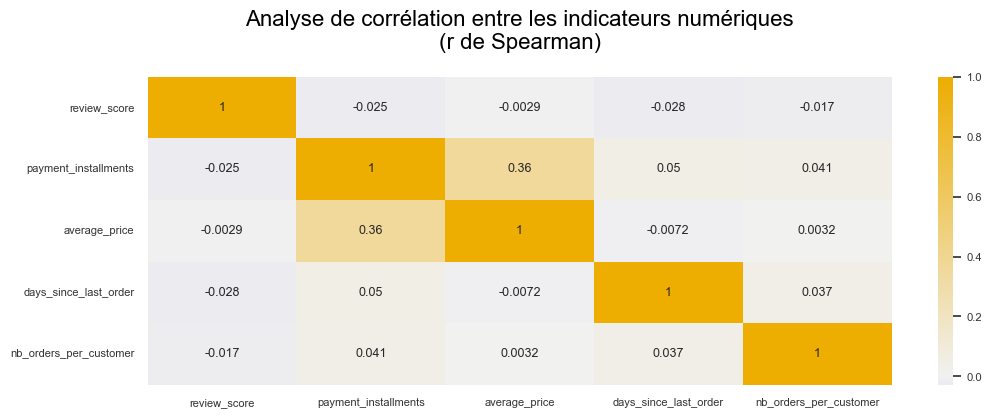

In [15]:
# Analysis of correlations between variables
plt.figure(figsize=(12,4))
sns.heatmap(df_cluster.corr(method="spearman"), center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('Analyse de corrélation entre les indicateurs numériques\n(r de Spearman)')
plt.show()

Globalement, les données ne présentent pas d'association à l'exception d'une légère association entre les variables `average_price` et `payment_installments`.

Les données sont centrées et réduites (moyenne=0; Ecart-type=1) afin d'être utilisées pour les différentes méthodes de clustering.

In [16]:
sc = StandardScaler()
X = sc.fit_transform(df_cluster)

### **2.1   K-Means**

La méthode des KMeans est testé dans un premier temps. 

Cette méthode consiste a sélectionner aléatoirement k points de données (k=nb de cluster) comme centroïdes et d'attribuer chaque point de données à l'un d'eux. Cela se fait en calculant la distance entre le point de données et chaque centroïde. Puis les positions des centroïdes K sont recalculés. Le nouveau centroïde d'un cluster est calculé en prenant la moyenne de tous les points de données dans le cluster.

#### **2.1-1   Mesure de Qualité**

Pour effectuer un clustering il est nécessaire de mentionner le nombre de cluster que l'on souhaite obtenir. Afin de définir ce nombre de manière optimale il faut utiliser des indices qui permettent de mesurer la qualité des clusters.

##### **Indice de Davies-Bouldin**

Cet indice compare la moyenne des distances intra-cluster avec les distances entre les centroïdes des clusters (mesurant la séparation des clusters). Un indice de Davies-Bouldin plus faible indique un meilleur clustering, car il signifie que les clusters sont plus compacts et mieux séparés.

L'indice de Davin-Bouldin est calculé pour un clusetering allant de 2 à 10 clusters. 

In [17]:
score_bouldin = []

for n_clust in range(2,10):
 # Clustering par K-means avec initialisation K-means++
 km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
 km.fit(X)
 # Récupération des clusters attribués à chaque individu
 clusters = km.labels_
 # Application de la mesure Davies Bouldin
 score_bouldin.append(davies_bouldin_score(X, km.labels_))

print(score_bouldin)

[1.6110071982533045, 1.23163869541353, 1.1919636711000252, 1.0043660630951332, 0.8973376301983434, 1.0183787500665182, 1.1268192955028655, 1.1836261512153825]


Les résultats montrent qu'un nombre de 6 clusters serait optimal pour la segmentation des clients. 

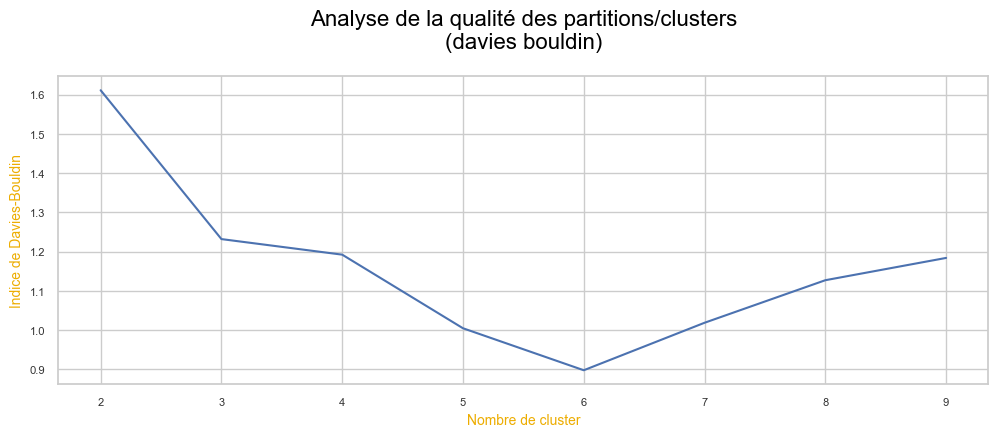

In [18]:
#Analyse des regroupements de clusters
plt.figure(figsize=(12,4))
plt.plot(range(2,10), score_bouldin)
plt.title('Analyse de la qualité des partitions/clusters\n(davies bouldin)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

##### **Indice de Silhouette**

In [ ]:
"""score_silhouette = []

for n_clust in range(2,10):
 # Clustering par K-means avec initialisation K-means++
 km = KMeans(n_clusters=n_clust, init='k-means++', n_init='auto', random_state=42, verbose=1)
 km.fit(X)
 # Récupération des clusters attribués à chaque individu
 clusters = km.labels_
 # Application de la mesure Silhouette
 score_silhouette.append(silhouette_score(X, km.labels_))
 print("silhouette terminé")

print(score_silhouette)"""

In [ ]:
#Analyse des regroupements de clusters
plt.figure(figsize=(12,4))
plt.plot(range(2,10), score_silhouette)
plt.title('Analyse de la qualité des partitions/clusters\n(silhouette)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Silhouette")
plt.show()

##### **4.1-2   Analyse des clusters**

In [ ]:
#Instanciation du nombre de clusters
n_clust = 5
#Instanciation du clustering k-means
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
#Application du K-means sur le data set
km.fit(X)
#Récupération des clusters attribués à chaque individu
clusters = km.labels_

In [ ]:
#Instanciation du df suite clustering
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
#Ajout de la colonne clusters + Remplissage avec le n° cluster correspondant
df_kmean['clusters'] = clusters
#print(df_kmean)

In [ ]:
#Moyenne des composantes par clusters
centroide_kmean = df_kmean.groupby(by='clusters').mean()

In [ ]:
#Création du heatmap pour observer les différents clusters et composantes
plt.figure(figsize=(14,4))
sns.heatmap(centroide_kmean, center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('K-Means - Analyse des clusters selon les indicateurs\n')
plt.ylabel('Clusters')
plt.show()

Analyse des clusters

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
plt.suptitle("Distribution des varibales par clusters")

for ax, column in zip(axs.flatten(), df_kmean.drop(columns="clusters").columns):
    sns.boxplot(x='clusters', y=column, data=df_kmean, ax=ax)
    

plt.tight_layout()
plt.show()

days_since_last_order = cluster 0 -> client les plus récent, plus le chiffre est bas, plus le client est récent.

In [ ]:
# Pour afficher les individus, adapter pour représenter graphiquement les clusters

"""import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14,10))

# 1er plan factoriel
scatter1 = axs[0, 0].scatter(x=coord[:, 0], y=coord[:, 1], c=df_customers.nb_orders_per_customer, s=6)
axs[0, 0].set_title("1er plan factoriel")
fig.colorbar(scatter1, ax=axs[0, 0])

# 2e plan factoriel
scatter2 = axs[0, 1].scatter(x=coord[:, 2], y=coord[:, 3], c=df_customers.nb_orders_per_customer, s=6)
axs[0, 1].set_title("2e plan factoriel")
fig.colorbar(scatter2, ax=axs[0, 1])

# 3e plan factoriel
scatter3 = axs[1, 0].scatter(x=coord[:, 4], y=coord[:, 5], c=df_customers.nb_orders_per_customer, s=6)
axs[1, 0].set_title("3e plan factoriel")
fig.colorbar(scatter3, ax=axs[1, 0])

# 4e plan factoriel
scatter4 = axs[1, 1].scatter(x=coord[:, 6], y=coord[:, 7], c=df_customers.nb_orders_per_customer, s=6)
axs[1, 1].set_title("4e plan factoriel")
fig.colorbar(scatter4, ax=axs[1, 1])

plt.tight_layout()
plt.show()"""

#### **4.2   CAH - Classification Ascendante Hiérarchique**

In [ ]:
# Instanciation du nombre de clusters
n_clust = 10000
# Instanciation du clustering k-means
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
# Application du K-means sur le data set
km.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

In [ ]:
# Instanciation du df suite clustering
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
# Ajout de la colonne clusters + Remplissage avec le n° cluster correspondant
df_kmean['clusters'] = clusters

In [ ]:
# Moyenne des composantes par clusters
centroide_kmean = df_kmean.groupby(by='clusters').mean()

In [ ]:
# Transformation - Centrage-Réduction / Mise à l'échelle (moyenne=0; Ecart-type=1)
X = sc.fit_transform(centroide_kmean)

In [ ]:
#Préparation des données pour le clustering
names = centroide_kmean.index.values

In [ ]:
#Clustering hiérarchique
Z = linkage(X, 'ward')

In [ ]:
#Mesure de similarité intercluster - Mesure de qualité d'une partition d'un ensemble de données
score = []

for n_clust in range(2,10):
  #Clustering par classification hiérarchique
  clusters = fcluster(Z, n_clust, criterion='maxclust')
  #Application de la mesure Davies Bouldin
  score.append(davies_bouldin_score(X, clusters))

print(score)

In [ ]:
#Analyse des regroupements de clusters
plt.figure(figsize=(14,4))
plt.plot(range(2,10), score)
plt.title('Analyse de la qualité des partitions/clusters\n')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

In [ ]:
#Affichage du dendrogramme
plt.figure(figsize=(10,25))
dendrogram(Z,labels=names,orientation='left',color_threshold=54, above_threshold_color='#bcbddc')
plt.title('CAH avec matérialisation des 8 classes\n')
plt.xlabel('Distance')
plt.ylabel('Classes')
plt.show()

In [ ]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 8, criterion='maxclust')
#Instanciation du df
df_cah = pd.DataFrame(X, columns=centroide_kmean.columns)
#Ajout de la colonne clusters + Remplissage avec le n cluster correspondant
df_cah['clusters'] = clusters
#print(df_cah)

In [ ]:
#Moyenne des composantes par clusters
centroids = df_cah.groupby(by='clusters').mean()

In [ ]:
#Observation du 1er plan factoriel avec représentation des individus par clusters
plt.figure(figsize=(10,6), dpi=80)
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
#centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1], label='Centroide', c='red')
plt.scatter(X_projected[:,0], X_projected[:,1], c=clusters.astype(float), alpha=.8, cmap=(mpl.colors.ListedColormap(['pink', 'green', 'blue', 'cyan', 'black', 'brown'])))
plt.colorbar()
plt.title("Projection des {} centres sur le 1e plan factoriel\n".format(len(centroids)), fontsize=18, color='#AA2D21')
plt.xticks(color='#36281B')
plt.yticks(color='#36281B')
plt.legend()
plt.show()

In [ ]:
#Création du heatmap pour observer les différents clusters et composantes
plt.figure(figsize=(14,4))
sns.heatmap(centroids, center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('CAH - Analyse des clusters selon les indicateurs\n')
plt.ylabel('Clusters')
plt.show()

In [ ]:
df_cah

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
plt.suptitle("Distribution des varibales par clusters")

for ax, column in zip(axs.flatten(), df_cah.drop(columns="clusters").columns):
    sns.boxplot(x='clusters', y=column, data=df_kmean, ax=ax)
    

plt.tight_layout()
plt.show()

#### **4.3   DBSCAN**

tester avec min_samples=100 et surtout faire une boucle pour teser plusieurs paramètre (type daviesbouldin).

In [ ]:
data_scaled = sc.fit_transform(df)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data_scaled)
df['cluster'] = dbscan.labels_

In [ ]:
df["cluster"].value_counts()

---

Recommencer dendogrammme avec AgglomerativeClustering pour automatiser le découpage à 8 clusters
Tester un nombre de cluster supérieur pour la curiosité

